In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import loompy
import numpy as np

from chromograph.preprocessing.utils import *
from chromograph.plotting.motif_plot import motif_plot
from cytograph.visualization.scatter import *
from cytograph.visualization.colors import Colorizer
from cytograph.plotting.dendrogram import dendrogram

In [2]:
## Replace paths to loom file with path to your local copies

build = '/proj/DEV_ATAC/Build_20220906_classes/' ## Folder containing loom files
f_peaks = os.path.join(build, 'Pool/Pool_peaks.loom')
f_peaks_agg = os.path.join(build, 'Pool/Pool_peaks.agg.loom')
f_RNA_imputed = os.path.join(build, 'Pool/Pool_RNA.loom')
f_RNA_agg = os.path.join(build, 'Pool/Pool_RNA.agg.loom')
f_motif = os.path.join(build, 'Pool/Pool_motifs.agg.loom')
f_GeneScore = os.path.join(build, 'Pool/Pool_GA.loom')

export_folder = '/datb/sl/camiel/scATAC/test_output'

<Figure size 504x504 with 0 Axes>

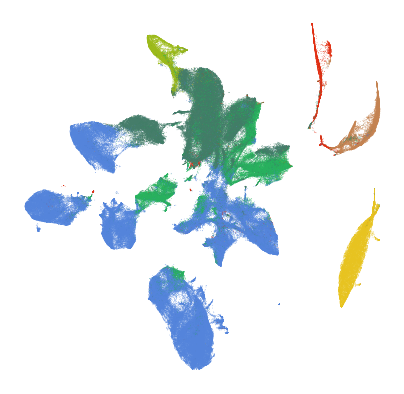

In [8]:
def assign_class(annotations):
    X = annotations.split(' ')
    if 'M-FBL' in X:
        return 'Fibroblast'
    elif any(a in X for a in ['M-MGL', 'M-IMMUNE']):
        return 'Immune'
    elif any(a in X for a in ['M-PER', 'M-ENDO']):
        return 'Vascular'
    elif 'OPC' in X:
        return 'Oligo'
    elif 'GBL' in X:
        return 'Glioblast'
    elif 'RGL' in X:
        return 'Radial glia'
    elif any(a in X for a in ['NEUR', 'NBL', 'NT-GABA', 'NT-VGLUT1', 'NT-VGLUT2', 'NT-VGLUT3','NT-GLY']):
        return 'Neuron'
    else:
        return 'Neuron'
    
plt.rc('legend',fontsize=12)
    
with loompy.connect(f_RNA_agg) as dsagg:
    with loompy.connect(f_RNA_imputed) as ds:
        Class = np.array([assign_class(x) for x in dsagg.ca.AutoAnnotation])
        cls2Class = {k:v for k,v in enumerate(Class)}
        Classes = np.array([cls2Class[x] for x in ds.ca.Clusters])
        plt.figure(figsize=(7,7))
        XY = ds.ca.Embedding
        labels = ds.ca.Class
        labels[np.where(labels=='Radial_glia')[0]] = Classes[np.where(labels=='Radial_glia')[0]] 

        plt.figure(figsize=(7,7))
        plt.axis('off')
        scatterc(XY, c=labels, colors='classes', legend=None)

        ## uncomment to plot labels on embedding
#         names, lbls = np.unique(labels, return_inverse=True)
#         for lbl in np.unique(lbls):
#             (x,y) = np.median(XY[np.where(lbls == lbl)[0]], axis=0)
#             plt.text(x, y, names[lbl], fontsize=12, color = 'black',bbox=dict(facecolor='white', alpha=0.3, ec='none',))
#             plt.title(f'Classes', fontsize=24)
        
        plt.savefig(os.path.join(export_folder, 'fig1_TSNE_classes_no_labels.png'), dpi=600, bbox_inches='tight')

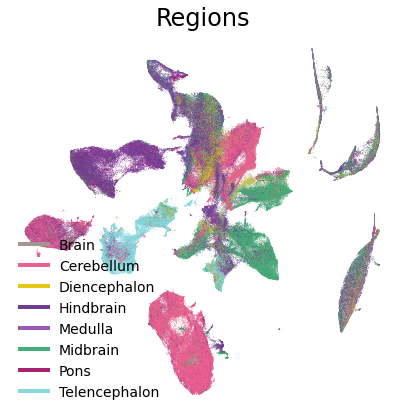

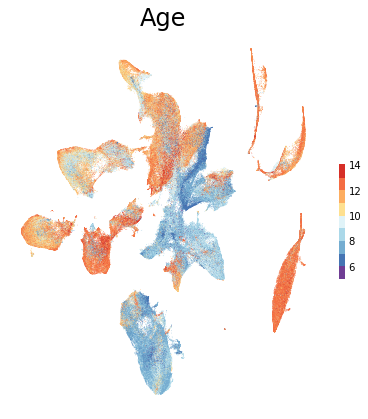

In [9]:
plt.rc('legend',fontsize=12)

with loompy.connect(f_peaks) as ds:
    XY = ds.ca.Embedding
    plt.figure(figsize=(7,7))
    plt.axis('off')
    scatterc(XY, c=ds.ca.regions, colors='regions', legend= 'lower left', font_size=14)  ## 'legend = None' to turn off legend
    plt.title(f'Regions', fontsize=24)
    plt.savefig(os.path.join(export_folder, 'fig1_Regions.png'), dpi=300, bbox_inches='tight')

    plt.figure(figsize=(7,7))
    plt.axis('off')
    scattern(XY, c=ds.ca.PseudoAge, cmap=Colorizer("age").cmap, vmin=5, vmax=14)
    plt.title(f'Age', fontsize=24)
    cbar = plt.colorbar(shrink = .3)
    cbar.ax.tick_params(size=0)
    cbar.outline.set_visible(False)

    plt.savefig(os.path.join(export_folder, 'fig1_Age.png'), dpi=300, bbox_inches='tight')

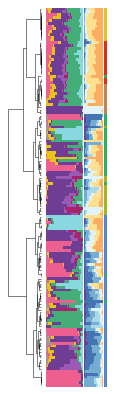

In [11]:
from cytograph.visualization.colors import *
from cytograph.plotting.dendrogram import dendrogram
from matplotlib.collections import LineCollection

height = 1       # the width of the bars: can also be len(x) sequence
colors = Colorizer(scheme='regions').dict()
with loompy.connect(f_peaks_agg) as ds:
    n_clusters = ds.shape[1]    
    labels = ['Brain', 'Cerebellum', 'Diencephalon', 'Hindbrain', 'Medulla', 'Pons', 'Midbrain', 'Telencephalon']
    keys = [f'Tissue_{k}' for k in labels]

    values = [(ds.ca[k]/ds.ca.NCells) for k in keys]
    bottoms = np.zeros(n_clusters)
    fig, ax = plt.subplots(1,4, figsize=(1.8,7), gridspec_kw={'width_ratios': [1,1,.5,.1]})
#     fig, ax = plt.subplots(1,4, figsize=(7.2, 28), gridspec_kw={'width_ratios': [1,1,.5,.1]})
    
    lc = dendrogram(ds.attrs.linkage, leaf_positions=np.arange(n_clusters), orientation='bottom')
    lc = LineCollection([np.flip(x,axis=1) for x in lc.get_segments()],colors='black', lw=.5)

    ax[0].add_collection(lc)
    ax[0].set_ylim(-.5, ds.shape[1])
    ax[0].set_xlim(-.1, ds.attrs.linkage[:, 2].max() * 1.1)
    ax[0].axis("off")
    
    for i in range(len(keys)):
        ax[1].barh(np.arange(n_clusters), values[i], left=bottoms, color=colors[labels[i]], height=height)
        bottoms = bottoms + values[i]
    
    ax[1].tick_params(left = False)
    
cmap=Colorizer("age").cmap
with loompy.connect(f_peaks) as ds:
    with loompy.connect(f_peaks_agg) as dsagg:
        ages = np.round(ds.ca.Age).astype(int)
        all_ages = sorted(np.unique(ages))
        values = []
        for a in all_ages:
            v = []
            for i in range(dsagg.shape[1]):
                v.append(np.sum((ages==a)&(ds.ca.Clusters==i))/dsagg.ca.NCells[i])
            values.append(np.array(v))
        values = np.array(values)
            
        bottoms = np.zeros(values.shape[1])
        for i in range(len(all_ages)):
            ax[2].barh(np.arange(values.shape[1]), values[i,:], left = bottoms, color = cmap.colors[i], height=height)
            bottoms = bottoms + values[i,:].flatten()

        cmap=Colorizer("classes").dict()
        labels = dsagg.ca.Class
        labels = ['Radial glia' if x == 'Radial_glia' else x for x in labels]

        ax[3].barh(np.arange(dsagg.shape[1]), np.ones(dsagg.shape[1]), color = [cmap[x] for x in labels], height=height)
    
    for i in [1,2,3]:
        ax[i].set_yticks([])
        ax[i].set_ylim((-.5,n_clusters))
        ax[i].set_xticks([])
    
    for axs in ax:
        for key, spine in axs.spines.items():
            spine.set_visible(False)
    plt.subplots_adjust(wspace=.05, hspace=0)
    plt.savefig(os.path.join(export_folder, 'fig1_annotation_distribution.png'), dpi=600, bbox_inches='tight')

[     0  25000  50000  75000 100000 125000]
OrderedDict([('polar', <matplotlib.spines.Spine object at 0x15117afcb0d0>), ('start', <matplotlib.spines.Spine object at 0x15117afcbb50>), ('end', <matplotlib.spines.Spine object at 0x15117beddd10>), ('inner', <matplotlib.spines.Spine object at 0x15117bedd710>)])


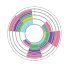

In [12]:
def Circular_age_distribution(ds: loompy.LoomConnection, out_file: str, gap:int = None, region_order = None, offset:float = 0, fraction_hole: float = 0) -> None:
    '''
    Generates a bubble plot to inspect distribution of cell counts across tissues.
    
    Args:
        ds                    Connection to the .loom file to use
        out_file              Name and location of the output file
        
    Remarks:
    
    '''
    
    tissue = np.unique(ds.ca.Tissue) 
    all_ages = np.unique(ds.ca.Age)
    df = pd.DataFrame([])
    for i, t in enumerate(tissue):
        age = np.floor(ds.ca.Age[np.where(ds.ca.Tissue==t)[0]].flatten()).astype(int)
        ages, cells = np.unique(age, return_counts=True)

        data = pd.DataFrame({'Regions': np.repeat(t, len(ages)), 'Age': ages, 'Cells': cells}, columns=['Regions', 'Age', 'Cells'])
        df = df.append(data)
    df = df.sort_values(['Age', 'Regions'], ascending=True)
    df = df.reset_index(drop=True)
    
    ages = sorted(np.unique(df['Age']))
    if region_order:
        regions = region_order
    else:
        regions = np.unique(df['Regions'])

    mn_age = np.min(ages)
    age_index = ages - mn_age
    values = np.zeros((np.max(age_index)+1, len(regions)))

    for i in range(np.max(age_index)+1):
        a = i + mn_age
        for j, r in enumerate(regions):
            x = df.loc[(df['Age']== a) & (df['Regions']==r)]

            if x.shape[0] == 1:
                values[i,j] = x['Cells']
    values = np.array(values)
    mx = np.max(np.sum(values,axis=1))
    
    hole_size = fraction_hole * mx
    bottoms = np.zeros(values.shape[0]) + hole_size
#     bottoms = np.zeros(values.shape[0])
    cmap=Colorizer("regions").dict()
    fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'), figsize=(1,1))
    
    x = np.arange(values.shape[0])[::-1]
    factor = ((2*np.pi)-gap) / np.max(x)
    x = x * factor
    x = x + .5*gap
    widths = np.diff(x)
    widths = np.hstack([widths, widths[-1]])
    for i in range(len(regions)):
        # First find radius for full cone
        cone = values[:,i] + bottoms
        r_cone = (cone / np.pi)**.5
        
        ## Subtract that off previous cone
        r_previous = (bottoms / np.pi)**.5
        r_new = r_cone - r_previous
    
        ## Plot new density
        ax.bar(x, r_new, bottom = r_previous, width=widths, edgecolor='black', lw = 0,
               align='edge', color = cmap[regions[i]], alpha=.9)
        bottoms = bottoms + values[:,i].flatten()
        
    mx = np.max(bottoms)
    mx = np.ceil((mx-hole_size)/1e4) * 1e4
    tick_labels = np.arange(0, mx+2.5e4, 2.5e4).astype(int)
    print(tick_labels)
    rticks = ((tick_labels + hole_size) /np.pi)**.5
    ax.set_rticks(rticks)
#     ax.set_yticklabels(tick_labels)
    ax.set_yticklabels([])

    ax.set_xticks([])
        
    print(ax.spines)
    ax.spines['end'].set_visible(False)
    ax.spines['start'].set_visible(False)
    ax.spines['polar'].set_visible(False)
    ax.spines['inner'].set_visible(False)
    # Set the direction of the zero angle
    ax.set_theta_offset(offset)
    
    plt.savefig(out_file, dpi=600, bbox_inches='tight')
    return
    
with loompy.connect(f_peaks) as ds:
    df = Circular_age_distribution(ds,os.path.join(export_folder, 'fig1_Counts_wheel_example.svg'), gap=.5*np.pi, offset = .5*np.pi,
                                   region_order = ['Brain', 'Telencephalon', 'Diencephalon', 'Midbrain', 'Hindbrain', 'Medulla',
                                                   'Pons', 'Cerebellum'], fraction_hole=.15)

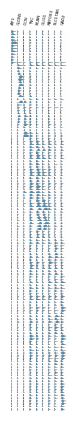

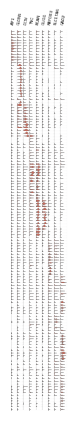

In [13]:
import seaborn as sns

genes  =  ['AIF1', 'CLDN5', 'DCN',  ## Mgl, Endo, Fib.
           'TNC', 'BCAN', 'OLIG1', ## RGL, GBL, OPC
           'RBFOX3', 'SLC17A6', 'GAD2' ## Neur, VGLUT2, GABA
          ]

with loompy.connect(f_GeneScore,'r') as ds:
    nrow = len(np.unique(ds.ca.Clusters))
    ncol = len(genes)

    h = 7
    w = 1
    fig, ax = plt.subplots(nrow, ncol, figsize=(w,h))

    for c, gene in enumerate(genes):
        x = np.where(ds.ra['Gene Name']==gene)[0]
        data = np.sum(ds['pooled'][x,:],axis=0)
        mx = np.max(data)

        for r in range(nrow):
            if r == 0:
                ax[r,c].set_title(gene, rotation = 80, fontsize=4)
            cls = nrow - r - 1
            x = np.where(ds.ca.Clusters == cls)[0]
            v = data[x]
            v = np.clip(v, 0, np.quantile(v,.999))
            sns.violinplot(x=v, ax=ax[r,c],orient='h', color='#4393c3', alpha=.75, inner=None, linewidth = .2, width=1, cut=0)
#             ax[r,c].axis('off')
            ax[r,c].set_yticks([])
            ax[r,c].set_xticks([])    
            ax[r,c].set(xlim=(0,mx))
            for axis in ['top','bottom','left','right']:
                ax[r,c].spines[axis].set_linewidth(0.01)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(os.path.join(export_folder, 'fig1_Gene_score_markers.png'), dpi=600, bbox_inches='tight')
    
with loompy.connect(f_RNA_imputed,'r') as ds:
    nrow = len(np.unique(ds.ca.Clusters))
    ncol = len(genes)

    fig, ax = plt.subplots(nrow, ncol, figsize=(w,h))

    for c, gene in enumerate(genes):
        x = np.where(ds.ra.Gene==gene)[0]
        data = np.sum(ds['pooled'][x,:],axis=0)
        data = np.log2(data+1)
        mx = np.max(data)

        for r in range(nrow):
            if r == 0:
                ax[r,c].set_title(gene, rotation = 80, fontsize=4)
            cls = nrow - r - 1
            x = np.where(ds.ca.Clusters == cls)[0]
            v = data[x]
            v = np.clip(v, 0, np.quantile(v,.999))
            sns.violinplot(x=v, ax=ax[r,c],orient='h', alpha=.75, color='#d6604d', inner=None, linewidth = .2, width=1, cut=0)
            ax[r,c].set_yticks([])
            ax[r,c].set_xticks([])    
            ax[r,c].set(xlim=(0,mx))
            for axis in ['top','bottom','left','right']:
                ax[r,c].spines[axis].set_linewidth(0.01)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(os.path.join(export_folder, 'fig1_Expression_markers.png'), dpi=600, bbox_inches='tight')

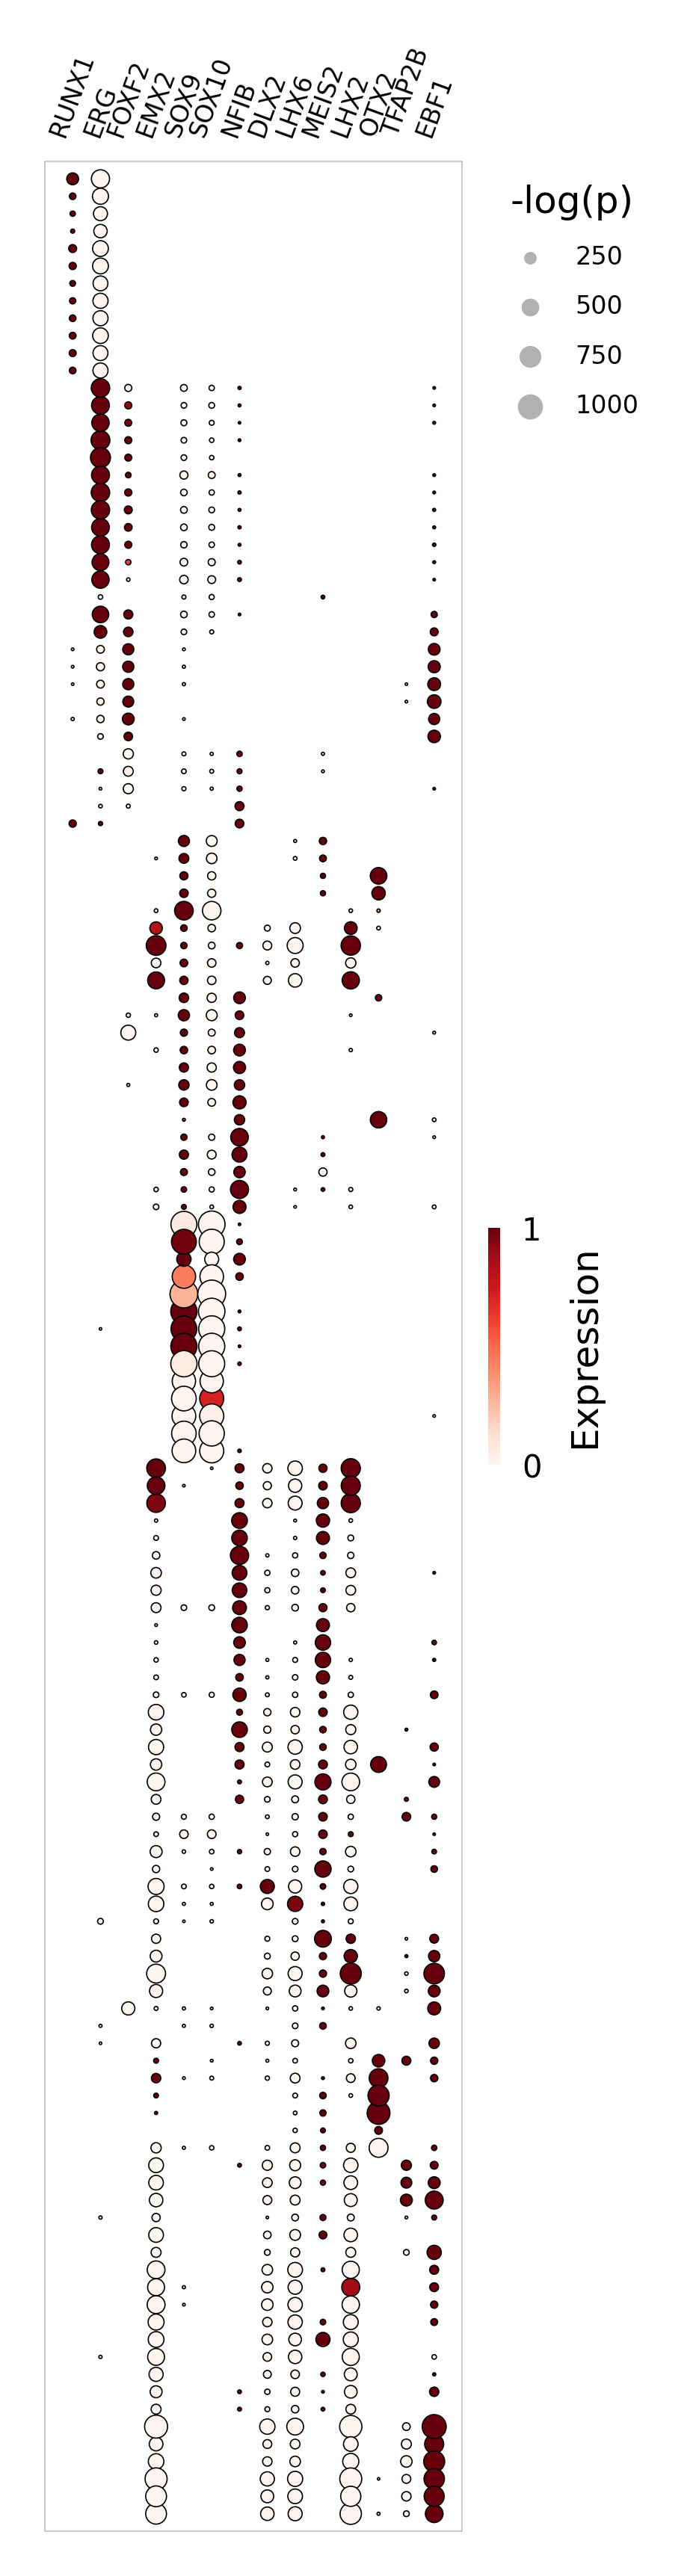

In [14]:
# Plot Transcription factor motifs

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import loompy
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection

def motif_plot_flipped(ds: loompy.LoomConnection, dsr: loompy.LoomConnection, out_file: str, TFs: list = None, threshold: float = None) -> None:
    '''
    Generates a multi-panel plot to inspect Motif enrichment scores. The clusters are on the vertical axis.
    
    Args:
        ds                    Connection to the .agg.loom motif file to use
        dsr                   Connection to the .agg.loom RNA file to use
        out_file              Name and location of the output file
        N                     The number of motifs to include per cluster (top N)
        
    Remarks:
    
    '''
    layer = '-log_pval'
    if '-log_pval_filtered' in ds.layers:
        layer = '-log_pval_filtered'

    if TFs:
        valids = np.isin(ds.ra.TF, TFs)
    else:
        valids = np.repeat(True,ds.shape[0])
    ds.ra.valids = np.zeros(ds.shape[0])
    ds.ra.valids[valids] = True
    
    mask = np.zeros(ds.shape[0], dtype=bool)
    mask[valids] = 1
    
    TF_order = np.zeros(ds.shape[0], dtype='int')
    TF_order[mask] = np.argmax(ds.layer[layer][np.where(mask)[0], :], axis=1)
    TF_order[~mask] = np.argmax(ds.layer[layer][np.where(~mask)[0], :], axis=1) + ds.shape[1]
    TF_order = np.argsort(TF_order)[::-1]
    ds.permute(TF_order, axis=0)
    
    shape_factor = len(valids)/ds.shape[1]

    layer = '-log_pval'
    x = np.where(ds.ra.valids)[0]
    pval = ds[layer][x,:]

    df = pd.DataFrame([])
    TF = [f'{ds.ra.TF[i]}' for i in x]
    xlabels = []
    rx = np.where(np.isin(dsr.ra.Gene, TF))
    genes = dsr.ra.Gene[rx]
    s = [np.where(genes==x)[0][0] for x in TF]
    for i in range(ds.shape[1]): 
        pvals = ds[layer][:,i][x]
        trin = dsr['trinaries'][:,i][rx][s]
        data = pd.DataFrame({'Cluster': i, 'TF': TF, 'p_vals': pvals, 'trinaries': trin}, columns=['Cluster', 'TF', 'p_vals', 'trinaries'])
        df = df.append(data)

    factor = np.max(df['p_vals']) / 20
    df['Bubble_size'] = df['p_vals'] / factor
    order = sorted(np.unique(df['Cluster']))
    df['Cluster'] = [order.index(x) for x in df['Cluster']]
    df = df.reset_index(drop=True)

    if threshold:
        df = df[df['p_vals'] > threshold] 
        df = df.reset_index(drop=True)

    d_order = {k:v for v,k in enumerate(TF)}
    df['order'] = np.array([d_order[x] for x in df['TF']])
    df = df.sort_values(ascending=True, by='order')
    
    h = 7
    w = 1.5
    fig, ax = plt.subplots(figsize=(w,h), dpi=600)
    h = lambda c: plt.Line2D([], [], color=c, ls="", marker="o")

    scatter = ax.scatter('TF', 'Cluster', s='Bubble_size', c='trinaries', cmap='Reds', data=df, edgecolors='black', lw=.2, label=None)
    cbar = fig.colorbar(scatter, ax=[ax], shrink=.1, location='right')
    cbar.set_label(label='Expression',size=6);
    cbar.ax.tick_params(size=0)
    cbar.set_ticks([0,1])
    cbar.ax.set_yticklabels([0,1], fontsize=5)
    cbar.outline.set_visible(False)
    for p in [250,500,750,1000]:
        plt.scatter([], [], c='k', alpha=0.3, s=p/factor, label=str(p), lw=0)
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, bbox_to_anchor=(1.05,1),
               title='-log(p)', title_fontsize=6, fontsize=4)

    plt.yticks([])
    plt.xticks(range(len(TF)), TF, fontsize=4, rotation=70)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    plt.ylim(-1, ds.shape[1])
    plt.xlim(-1, len(x))
    ax.xaxis.tick_top()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.05)
    plt.savefig(out_file, bbox_inches='tight', dpi=600)
    
f_motif_all = os.path.join(build, f'Pool/Pool_motifs.agg.loom')
f_RNA_agg_all = os.path.join(build, f'Pool/Pool_RNA.agg.loom')

motifs = ['RUNX1', 'ERG', 'FOXF2',
          'SOX9', 'LHX6', 'DLX2', ## TEST
         'SOX10', 'NFIB', 'EBF1',
         'OTX2', 'EMX2', 'MEIS2',
         'LHX2', 'TFAP2B', 'EBF1']

with loompy.connect(f_motif_all) as ds:
    with loompy.connect(f_RNA_agg_all) as dsr:
        motif_plot_flipped(ds,dsr, out_file = os.path.join(export_folder, 'fig1_motifs.png'), TFs=motifs, threshold = 10)